In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [2]:
exp_name = "200904_mnist"
use_eval_runs = True

In [3]:
train_files = f"../results/{exp_name}/*/config.json"
eval_files = f"../results/{exp_name}/*/eval/*/config.json"

In [4]:
if use_eval_runs:
    files = eval_files
else:
    files = train_files

In [5]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior"):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x=x, y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

In [6]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [7]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [8]:
runs_all.head()

,accuracy_eval,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,calibration_eval,config_file,...,auroc,lp_mean,lp_std,lp_stderr,ace,ece,rmsce,simple_logmarglik,simple_marglik,error_mean
0,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/21/config.json,...,0.808328,-7.17805,4.44838,0.0444838,NaN,NaN,NaN,NaN,NaN,0.929901
1,True,64,True,0,gaussian,{},1,10,True,../results/200904_mnist/21/config.json,...,NaN,-0.90996,1.88963,0.0109098,0.0207254,0.0787537,0.00668745,NaN,NaN,0.237976
2,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/21/config.json,...,NaN,-0.0757862,0.3253,0.00325299,NaN,NaN,NaN,-1.40421e+06,0,0.027534
3,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/84/config.json,...,0.727091,-2.44494,0.393098,0.00393098,NaN,NaN,NaN,NaN,NaN,0.917955
4,True,64,True,0,gaussian,{},1,10,False,../results/200904_mnist/84/config.json,...,NaN,-1.5064,0.421688,0.00421688,NaN,NaN,NaN,-8.30361e+08,0,0.640009


In [9]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

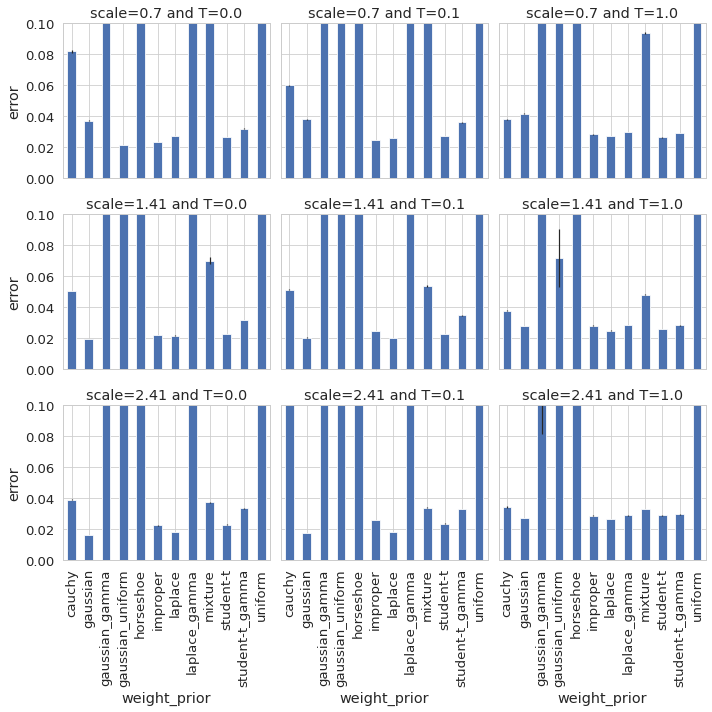

In [10]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [11]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

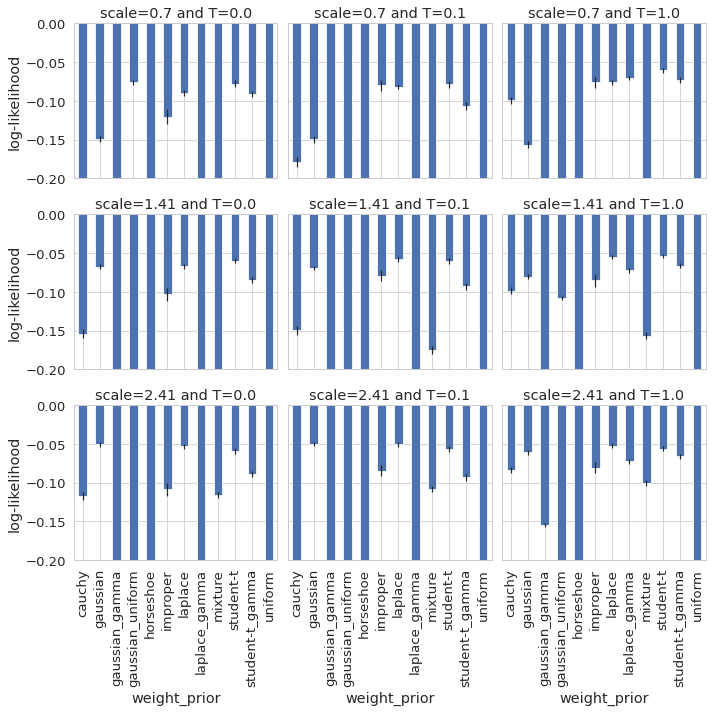

In [12]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [13]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [14]:
components = ["gaussian", "laplace", "student-t", "cauchy"]

df_mixture = pd.DataFrame(columns=["weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[-1], dim=0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [scale, temp, layer, comp, weight, np.log(weight)]

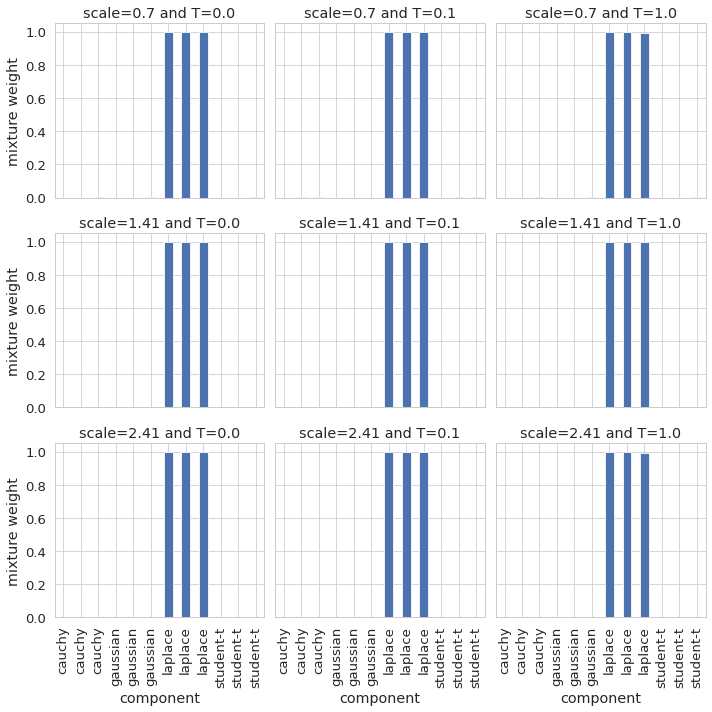

In [15]:
fig = plot_grid(df_mixture, y="weight", ylabel="mixture weight", x="component")

In [16]:
fig.savefig(f"../figures/{exp_name}_mixture_weights.pdf")

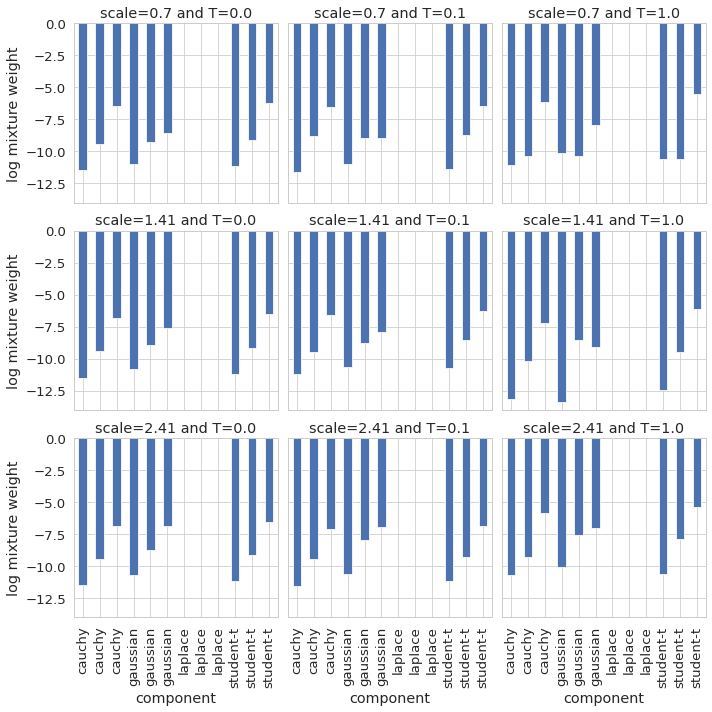

In [17]:
fig = plot_grid(df_mixture, y="log_weight", ylabel="log mixture weight", x="component")

In [18]:
fig.savefig(f"../figures/{exp_name}_mixture_logweights.pdf")

In [19]:
runs_selected = runs_selected[runs_selected.weight_prior.apply(lambda val: val not in ["improper", "uniform", "mixture"])]

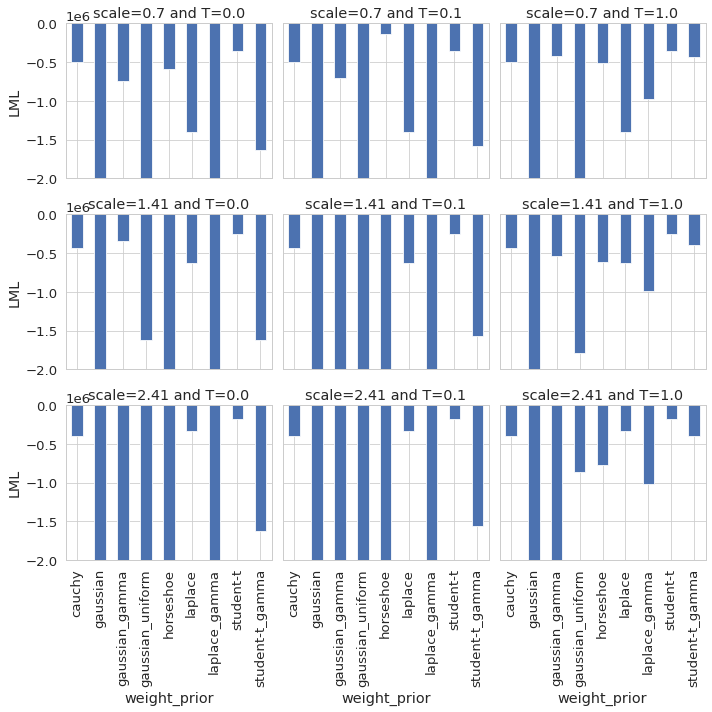

In [20]:
fig = plot_grid(runs_selected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [21]:
fig.savefig(f"../figures/{exp_name}_logmargliks.pdf")

In [22]:
margliks = runs_selected["simple_logmarglik"].values.astype(float)
lls = runs_selected["lp_mean"].values.astype(float)
accs = runs_selected["acc_mean"].values.astype(float)

In [23]:
print("Correlation between log marginal likelihoods and test log likelihoods:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

print("Correlation between log marginal likelihoods and test errors:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))

Correlation between log marginal likelihoods and test log likelihoods:
Pearson's r = 0.377 with p-value = 5.24e-04
Spearman's rho = 0.470 with p-value = 9.59e-06
Kendall's tau = 0.360 with p-value = 2.17e-06
Correlation between log marginal likelihoods and test errors:
Pearson's r = 0.377 with p-value = 5.30e-04
Spearman's rho = 0.408 with p-value = 1.59e-04
Kendall's tau = 0.310 with p-value = 4.96e-05


In [24]:
assert use_eval_runs, "The calibration and OOD can only be assessed on eval data"

In [25]:
runs_selected = runs_all.query("eval_data == 'rotated_mnist'")

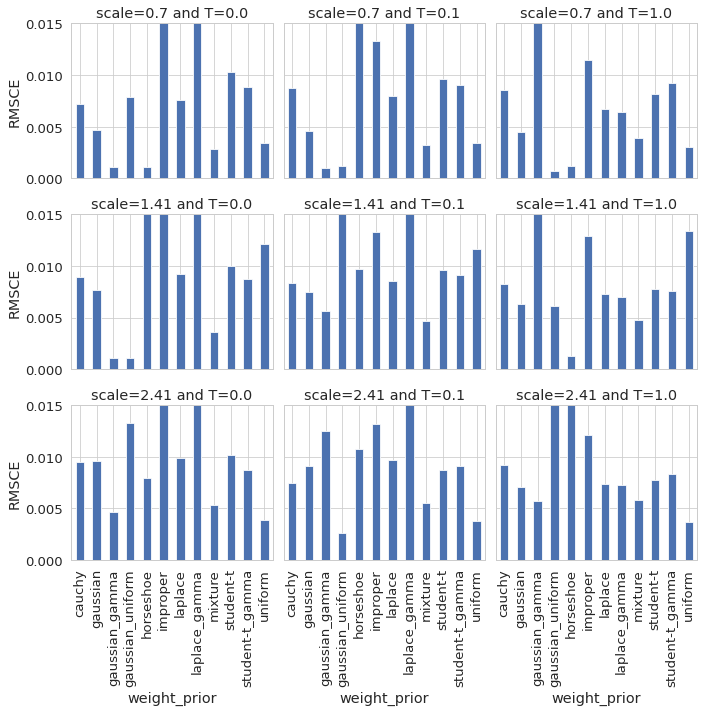

In [26]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [27]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

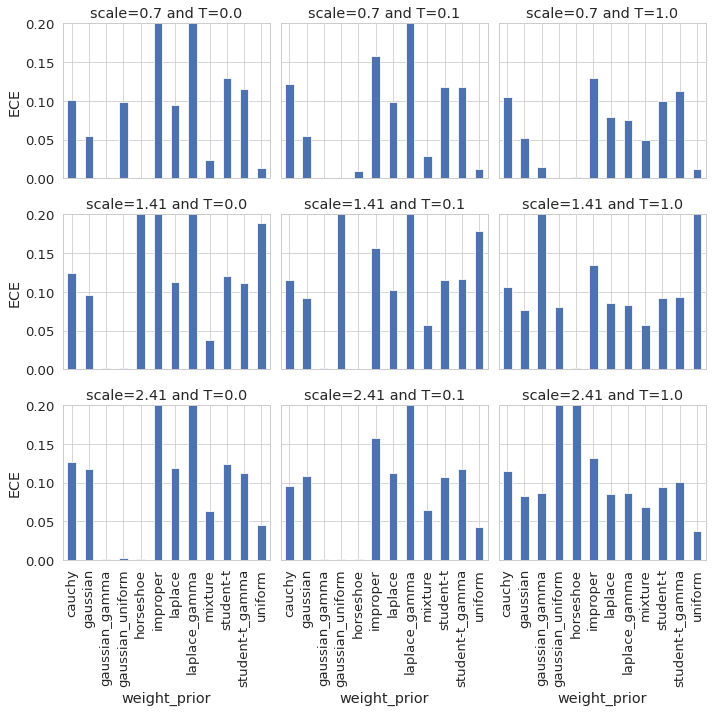

In [28]:
fig = plot_grid(runs_selected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [29]:
fig.savefig(f"../figures/{exp_name}_ece.pdf")

In [30]:
runs_selected = runs_all.query("eval_data == 'fashion_mnist'")

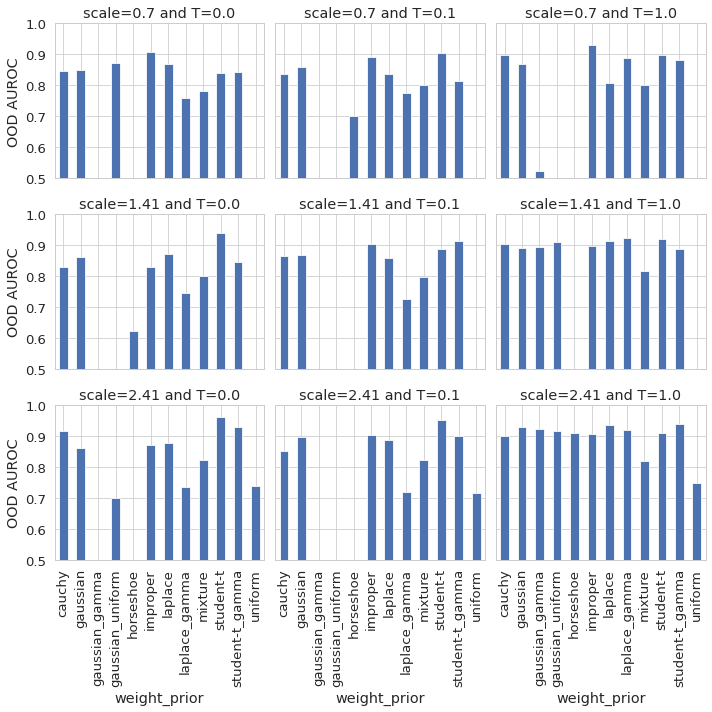

In [31]:
fig = plot_grid(runs_selected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [32]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

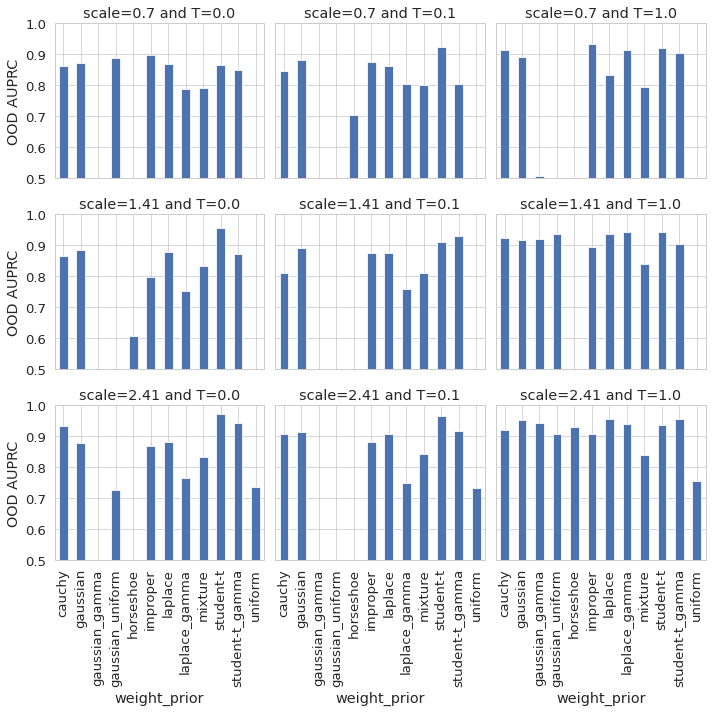

In [33]:
fig = plot_grid(runs_selected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [34]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")